### WIP Sentiment Analysis
#### Tutorial links
https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/




In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
plt.style.use('ggplot')
nltk.download('all-corpora')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('vader_lexicon')
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette('vlag')

[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | D

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# read the data
# Initialize an empty DataFrame to store the data
reviews = pd.DataFrame()

# Define the file path
file_path = '/gdrive/My Drive/ADC/yelp_project/datasets/tucson_reviews.csv'

# Specify the chunk size
chunksize = 100000

# Read the file in chunks and concatenate them
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    reviews = pd.concat([reviews, chunk])

# Now, 'reviews' contains the entire dataset

In [4]:
# show the data
reviews.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
1,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26
2,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04
3,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,0,1,1,Blew $80 on food for the family was worth it f...,2013-12-29 03:15:34
4,_u331rYIp7qJ7aWvLup9Ug,BUpAhzsbbKbTqyBjT8YnNQ,wa_bwyY57etHjtJ2Fw0E3g,5,0,0,0,Called in a Mediterranean chicken shawarma. Go...,2014-04-01 05:00:09


In [5]:
# read business data
business = pd.read_csv('/gdrive/My Drive/ADC/yelp_project/datasets/tucson_business.csv')

In [6]:
# show business data
business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.250960,-110.959158,4.0,446,1,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21..."
1,Y3ZCO17N1_T_Ms1JmswwzA,Taqueria Pico De Gallo,2618 S 6th Ave,Tucson,AZ,85713,32.192017,-110.968540,4.0,397,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","Mexican, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ..."
2,lhsQkb5nhf-Kd5OvgB9MNg,Sachiko Sushi,3210 E Valencia Rd,Tucson,AZ,85706,32.133679,-110.923443,3.5,191,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Japanese, Restaurants, Sushi Bars","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
3,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.046320,4.5,258,1,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
4,-3-6BB10tIWNKGEF0Es2BA,The 81 Hong Kong Cafe,"625 E Wetmore Rd, Ste 109",Tucson,AZ,85705,32.288540,-110.963144,4.0,133,1,"{'Alcohol': ""u'none'"", 'DogsAllowed': 'False',...","Coffee & Tea, Asian Fusion, Food, Bubble Tea, ...","{'Monday': '0:0-0:0', 'Wednesday': '10:0-21:0'..."
5,UCMSWPqzXjd7QHq7v8PJjQ,Prep & Pastry,2660 N Campbell Ave,Tucson,AZ,85719,32.255528,-110.943492,4.5,2126,1,"{'Alcohol': ""u'full_bar'"", 'BikeParking': 'Tru...","Restaurants, Cocktail Bars, Bars, Comfort Food...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '..."
6,aq26RY75PlTNsviW6wUC9A,Hooters,7280 E Broadway Blvd,Tucson,AZ,85710,32.220600,-110.837971,3.5,109,1,"{'Alcohol': ""'full_bar'"", 'RestaurantsAttire':...","Sports Bars, Food, American (Traditional), Nig...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
7,8QJTzIaR5FceGds8HBSIig,Barrio Brewing,800 E 16th St,Tucson,AZ,85719,32.214412,-110.959512,4.0,611,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Nightlife, Sports Bars, Bars, Breweries, Pubs,...","{'Monday': '11:0-19:0', 'Tuesday': '11:0-22:0'..."
8,5Ce3lZksYVkCbrihqylVHQ,Sushi Nara,64 N Harrison Rd,Tucson,AZ,85748,32.222552,-110.788132,4.5,159,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'True...","Sushi Bars, Japanese, Restaurants","{'Monday': '16:30-20:0', 'Tuesday': '16:30-20:..."
9,-y5vYOsyL4bSFxeOtQtYbg,AJ's Fine Foods,2805 E Skyline Dr,Tucson,AZ,85718,32.324425,-110.931614,4.0,258,1,"{'GoodForKids': 'True', 'Caters': 'True', 'Out...","Delis, Bakeries, Food, Grocery, Restaurants","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."


In [7]:
# join the files using business id
tucson_data = pd.merge(business, reviews, on='business_id')

In [8]:
# show the new data
tucson_data.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",xnA_bGa4zJ7fLUPTOCT0-A,nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",453I3aMT_YCQW655gKkzdQ,SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QTE44bHheG6ugQU4em4SdQ,B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",5f42pKbzLJWwtsa0StDwgA,OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-vIuycScTA7SVwHDi1ENeg,QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48
5,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",PdSiuKq-zR6msuU1Rs3n-g,yUngqxBzqCgcdL4heo4Heg,5,0,0,0,"Everybody in our lab is a fan of their food, a...",2018-09-14 22:24:42
6,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",qRWMrRowaqlwcezBpwgsTw,iR2pcr2ssSBAM446HeT2hA,2,1,1,0,"Service = pleasant, but not outstanding by any...",2010-11-22 15:14:21
7,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",K1opRk4GKwUUtBp6K2cocg,7AcGs_uVHFcnoHsKETBy7g,4,1,0,0,I've become a fan of Sher-e Punjab over the la...,2009-08-08 22:18:48
8,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",CqDc5QznNTCgyZQSxeq25A,-f4o4UgaTqfolTsWZswjYw,5,1,0,0,Best Indian food I have had in Tucson! Veggie ...,2016-07-04 07:16:29
9,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",vdrOv8KhWSaN8H68cxjWBQ,axhEZ874NTw_e2A5R9HSjg,5,0,0,0,BEST Indian food I have ever had. Their tikka ...,2016-12-20 00:49:59


In [9]:
# filter the data to only contain Tucson city data and restaurants
#tucson_data = reviws_business.loc[reviws_business['city'] == 'Tucson' & reviws_business['categories'] == 'Restaurant']

#tucson_data = reviws_business[reviws_business['categories'].str.contains('Restaurant', case=False) & (reviws_business['city'] == 'Tucson')]


In [10]:
# show the new Tucson data
tucson_data.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",xnA_bGa4zJ7fLUPTOCT0-A,nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",453I3aMT_YCQW655gKkzdQ,SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QTE44bHheG6ugQU4em4SdQ,B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",5f42pKbzLJWwtsa0StDwgA,OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-vIuycScTA7SVwHDi1ENeg,QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48
5,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",PdSiuKq-zR6msuU1Rs3n-g,yUngqxBzqCgcdL4heo4Heg,5,0,0,0,"Everybody in our lab is a fan of their food, a...",2018-09-14 22:24:42
6,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",qRWMrRowaqlwcezBpwgsTw,iR2pcr2ssSBAM446HeT2hA,2,1,1,0,"Service = pleasant, but not outstanding by any...",2010-11-22 15:14:21
7,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",K1opRk4GKwUUtBp6K2cocg,7AcGs_uVHFcnoHsKETBy7g,4,1,0,0,I've become a fan of Sher-e Punjab over the la...,2009-08-08 22:18:48
8,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",CqDc5QznNTCgyZQSxeq25A,-f4o4UgaTqfolTsWZswjYw,5,1,0,0,Best Indian food I have had in Tucson! Veggie ...,2016-07-04 07:16:29
9,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",vdrOv8KhWSaN8H68cxjWBQ,axhEZ874NTw_e2A5R9HSjg,5,0,0,0,BEST Indian food I have ever had. Their tikka ...,2016-12-20 00:49:59


In [11]:
# show a text review example
tucson_data['text'].values[0]

'One of my most favorite Indian restaurants. Nothing fancy but absolutely delicious meals.\n\nNever an issue being seated promptly. A casual dining experience awaits. Service is pleasant. Ambience a bit blahh but still enjoyable.\n\nNow onto the real reason to come here... the FOOD:\nNaan is soft. Garlic is tasty but I usually like the original best.  Regardless of your entree of choice, you really cannot go wrong. And although it does not appeal to my level of spiciness preferred (I like it HOT HOT HOT), it has great flavor and is great for the average spicey food eater. My recommendations are the Masala or Vindaloo (Chicken, Shrimp, Lamb... option is yours). Room for dessert? Order the Rice Pudding  and Gulab Jaman, mix together and enjoy the creamy sugary treat.'

In [12]:
# show the shape and sample to 500
print(tucson_data.shape)
tucson_sample = tucson_data.head(500)
print(tucson_sample.shape)

(191113, 22)
(500, 22)


### EDA

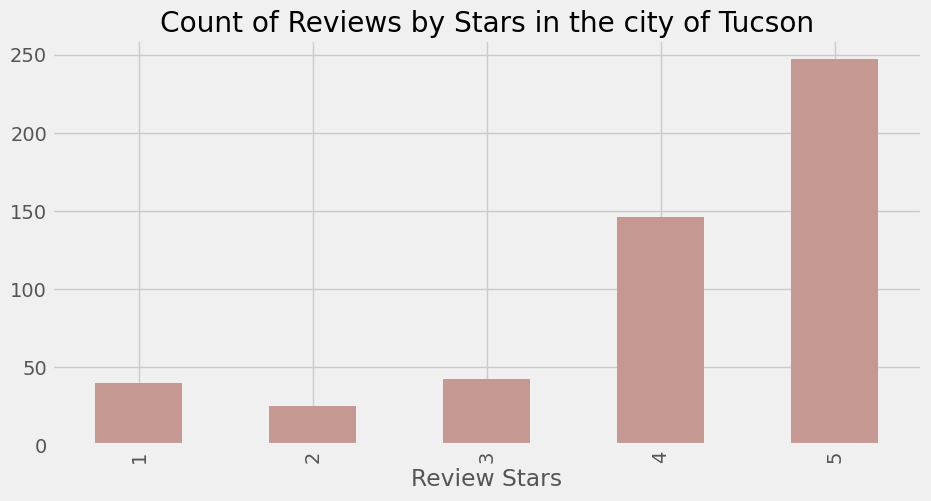

In [13]:
# show the number of time each rating/stars occurs
ax = tucson_sample['stars_y'].value_counts().sort_index().plot(kind='bar',
          title='Count of Reviews by Stars in the city of Tucson',
          figsize=(10, 5), color='#c59992')
ax.set_xlabel('Review Stars')
plt.show()

### Starting with NLTK

Basic analysis with one example

In [14]:
example = tucson_sample['text'].values[50]
print(example)

This place has the BEST Chicken Tikka Masala I've had after coming to the US. The NAAN is also SOOOO good! I ordered food from here twice during my 5 day visit to Tucson. Love this place!!


In [15]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This',
 'place',
 'has',
 'the',
 'BEST',
 'Chicken',
 'Tikka',
 'Masala',
 'I',
 "'ve"]

In [16]:
# part of speach values
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('place', 'NN'),
 ('has', 'VBZ'),
 ('the', 'DT'),
 ('BEST', 'NNP'),
 ('Chicken', 'NNP'),
 ('Tikka', 'NNP'),
 ('Masala', 'NNP'),
 ('I', 'PRP'),
 ("'ve", 'VBP')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  place/NN
  has/VBZ
  the/DT
  (ORGANIZATION BEST/NNP Chicken/NNP Tikka/NNP)
  Masala/NNP
  I/PRP
  've/VBP
  had/VBN
  after/IN
  coming/VBG
  to/TO
  the/DT
  (GSP US/NNP)
  ./.
  The/DT
  (ORGANIZATION NAAN/NNP)
  is/VBZ
  also/RB
  (ORGANIZATION SOOOO/NNP)
  good/JJ
  !/.
  I/PRP
  ordered/VBD
  food/NN
  from/IN
  here/RB
  twice/RB
  during/IN
  my/PRP$
  5/CD
  day/NN
  visit/NN
  to/TO
  (PERSON Tucson/NNP)
  ./.
  Love/VB
  this/DT
  place/NN
  !/.
  !/.)


### Starting with Vader
Classify the sentences by Positive, Neutral, or Negative

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia

In [20]:
# example with the neg/ney/pos
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [21]:
# example with a negative sentence
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [22]:
# run sia on the tucson example
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.713, 'pos': 0.287, 'compound': 0.9314}

In [23]:
# run the polarity score on the entire tucson sample
res = {}
for i, row in tqdm(tucson_sample.iterrows(), total=len(tucson_sample)):
    text = row['text']
    myid = row['review_id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
# show the result dictionary
res

{'xnA_bGa4zJ7fLUPTOCT0-A': {'neg': 0.0,
  'neu': 0.66,
  'pos': 0.34,
  'compound': 0.9959},
 '453I3aMT_YCQW655gKkzdQ': {'neg': 0.12,
  'neu': 0.435,
  'pos': 0.445,
  'compound': 0.7901},
 'QTE44bHheG6ugQU4em4SdQ': {'neg': 0.0,
  'neu': 0.654,
  'pos': 0.346,
  'compound': 0.7019},
 '5f42pKbzLJWwtsa0StDwgA': {'neg': 0.025,
  'neu': 0.763,
  'pos': 0.212,
  'compound': 0.9005},
 '-vIuycScTA7SVwHDi1ENeg': {'neg': 0.05,
  'neu': 0.784,
  'pos': 0.166,
  'compound': 0.992},
 'PdSiuKq-zR6msuU1Rs3n-g': {'neg': 0.0,
  'neu': 0.816,
  'pos': 0.184,
  'compound': 0.8976},
 'qRWMrRowaqlwcezBpwgsTw': {'neg': 0.102,
  'neu': 0.801,
  'pos': 0.097,
  'compound': -0.0413},
 'K1opRk4GKwUUtBp6K2cocg': {'neg': 0.038,
  'neu': 0.734,
  'pos': 0.229,
  'compound': 0.9922},
 'CqDc5QznNTCgyZQSxeq25A': {'neg': 0.114,
  'neu': 0.557,
  'pos': 0.328,
  'compound': 0.8065},
 'vdrOv8KhWSaN8H68cxjWBQ': {'neg': 0.05,
  'neu': 0.555,
  'pos': 0.396,
  'compound': 0.8967},
 'YUIujIaQl_1tw6qp-OD5vg': {'neg': 0.0,
 

In [25]:
# store the results dictionary in a dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'review_id'})
vaders = vaders.merge(tucson_sample, how='left')

In [26]:
# show vader dataframe with the sentiment score
vaders.head(10)

,review_id,neg,neu,pos,compound,business_id,name,address,city,state,...,attributes,categories,hours,user_id,stars_y,useful,funny,cool,text,date
0,xnA_bGa4zJ7fLUPTOCT0-A,0.000,0.660,0.340,0.9959,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,453I3aMT_YCQW655gKkzdQ,0.120,0.435,0.445,0.7901,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,QTE44bHheG6ugQU4em4SdQ,0.000,0.654,0.346,0.7019,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,5f42pKbzLJWwtsa0StDwgA,0.025,0.763,0.212,0.9005,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,-vIuycScTA7SVwHDi1ENeg,0.050,0.784,0.166,0.9920,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48
5,PdSiuKq-zR6msuU1Rs3n-g,0.000,0.816,0.184,0.8976,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",yUngqxBzqCgcdL4heo4Heg,5,0,0,0,"Everybody in our lab is a fan of their food, a...",2018-09-14 22:24:42
6,qRWMrRowaqlwcezBpwgsTw,0.102,0.801,0.097,-0.0413,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",iR2pcr2ssSBAM446HeT2hA,2,1,1,0,"Service = pleasant, but not outstanding by any...",2010-11-22 15:14:21
7,K1opRk4GKwUUtBp6K2cocg,0.038,0.734,0.229,0.9922,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",7AcGs_uVHFcnoHsKETBy7g,4,1,0,0,I've become a fan of Sher-e Punjab over the la...,2009-08-08 22:18:48
8,CqDc5QznNTCgyZQSxeq25A,0.114,0.557,0.328,0.8065,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-f4o4UgaTqfolTsWZswjYw,5,1,0,0,Best Indian food I have had in Tucson! Veggie ...,2016-07-04 07:16:29
9,vdrOv8KhWSaN8H68cxjWBQ,0.050,0.555,0.396,0.8967,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",axhEZ874NTw_e2A5R9HSjg,5,0,0,0,BEST Indian food I have ever had. Their tikka ...,2016-12-20 00:49:59


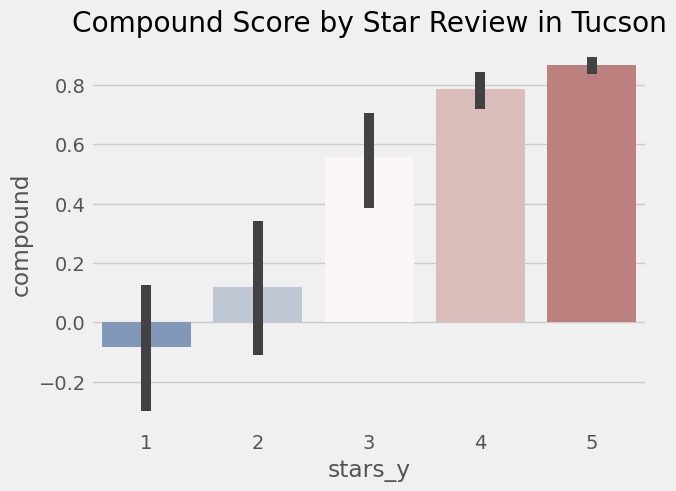

In [27]:
# let's plot the results
ax = sns.barplot(data=vaders, x='stars_y', y='compound', palette='vlag')
ax.set_title('Compound Score by Star Review in Tucson')
plt.show()

# lower star ratings have lower compound scores!

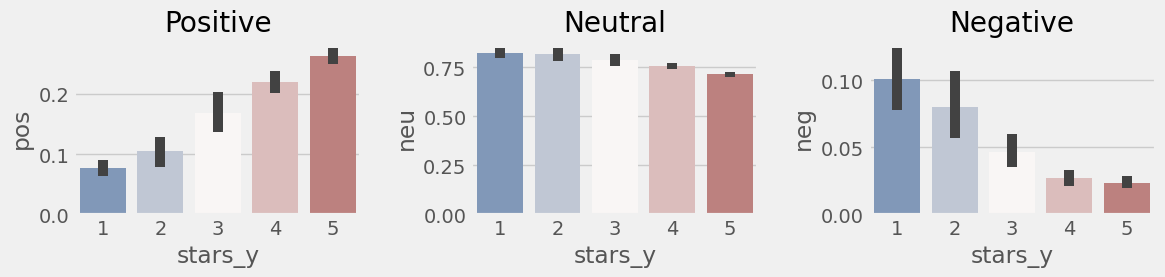

In [28]:
#let's plot each of the sentiments in separate plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='stars_y', y='pos', ax=axs[0], palette='vlag')
sns.barplot(data=vaders, x='stars_y', y='neu', ax=axs[1], palette='vlag')
sns.barplot(data=vaders, x='stars_y', y='neg', ax=axs[2], palette='vlag')
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# the higher the star rating, the nicer the reviews

### Trying the Roberta pre-trained model

In [29]:
# imports
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00


In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [31]:
# let's see the vader results to compare with the roberta results
# VADER results on example
print(example)
sia.polarity_scores(example)

This place has the BEST Chicken Tikka Masala I've had after coming to the US. The NAAN is also SOOOO good! I ordered food from here twice during my 5 day visit to Tucson. Love this place!!


{'neg': 0.0, 'neu': 0.713, 'pos': 0.287, 'compound': 0.9314}

In [32]:
# now let's see the same sentence example for roberta
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0017596377, 'roberta_neu': 0.006223794, 'roberta_pos': 0.99201655}


In [33]:
# now let's apply it to the entire tucson sample

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [34]:
res = {}
for i, row in tqdm(tucson_sample.iterrows(), total=len(tucson_sample)):
    try:
        text = row['text']
        myid = row['review_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 4C9EstICIoP6Kz4sWpqRkQ
Broke for id 2VLvvwHZ6xJ_q6oUYyFhVg
Broke for id uWDAPbfIQm9axGBWH9yDKw
Broke for id ztmTo2AHXURRZtZnucokpQ
Broke for id L7Rl4CkHHLAIGBFYl1y1FA
Broke for id foAEC-AHqkasm84-O6lHKQ
Broke for id yNAmr9WPJjC05wTXiIap9A


###Note
when it breaks, it means it had difficulties running through the Roberta model

In [35]:
results_tucson = pd.DataFrame(res).T
results_tucson = results_tucson.reset_index().rename(columns={'index': 'review_id'})
results_tucson = results_tucson.merge(tucson_sample, how='left')

In [36]:
# show the new dataframe
# it has the vader and roberta results!
results_tucson.head(10)

,review_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,business_id,name,...,attributes,categories,hours,user_id,stars_y,useful,funny,cool,text,date
0,xnA_bGa4zJ7fLUPTOCT0-A,0.000,0.660,0.340,0.9959,0.004157,0.025986,0.969858,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,453I3aMT_YCQW655gKkzdQ,0.120,0.435,0.445,0.7901,0.065281,0.278134,0.656585,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,QTE44bHheG6ugQU4em4SdQ,0.000,0.654,0.346,0.7019,0.153493,0.431414,0.415093,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,5f42pKbzLJWwtsa0StDwgA,0.025,0.763,0.212,0.9005,0.011490,0.070526,0.917984,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,-vIuycScTA7SVwHDi1ENeg,0.050,0.784,0.166,0.9920,0.011648,0.125766,0.862585,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48
5,PdSiuKq-zR6msuU1Rs3n-g,0.000,0.816,0.184,0.8976,0.003465,0.015569,0.980966,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",yUngqxBzqCgcdL4heo4Heg,5,0,0,0,"Everybody in our lab is a fan of their food, a...",2018-09-14 22:24:42
6,qRWMrRowaqlwcezBpwgsTw,0.102,0.801,0.097,-0.0413,0.853592,0.125583,0.020825,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",iR2pcr2ssSBAM446HeT2hA,2,1,1,0,"Service = pleasant, but not outstanding by any...",2010-11-22 15:14:21
7,K1opRk4GKwUUtBp6K2cocg,0.038,0.734,0.229,0.9922,0.017516,0.111063,0.871421,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",7AcGs_uVHFcnoHsKETBy7g,4,1,0,0,I've become a fan of Sher-e Punjab over the la...,2009-08-08 22:18:48
8,CqDc5QznNTCgyZQSxeq25A,0.114,0.557,0.328,0.8065,0.001375,0.010406,0.988219,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-f4o4UgaTqfolTsWZswjYw,5,1,0,0,Best Indian food I have had in Tucson! Veggie ...,2016-07-04 07:16:29
9,vdrOv8KhWSaN8H68cxjWBQ,0.050,0.555,0.396,0.8967,0.001548,0.007221,0.991231,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,...,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",axhEZ874NTw_e2A5R9HSjg,5,0,0,0,BEST Indian food I have ever had. Their tikka ...,2016-12-20 00:49:59


### Compare Vader and Roberta

In [37]:
# show the columns
results_tucson.columns

Index(['review_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'business_id', 'name',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars_x', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'user_id', 'stars_y', 'useful', 'funny', 'cool', 'text',
       'date'],
      dtype='object')

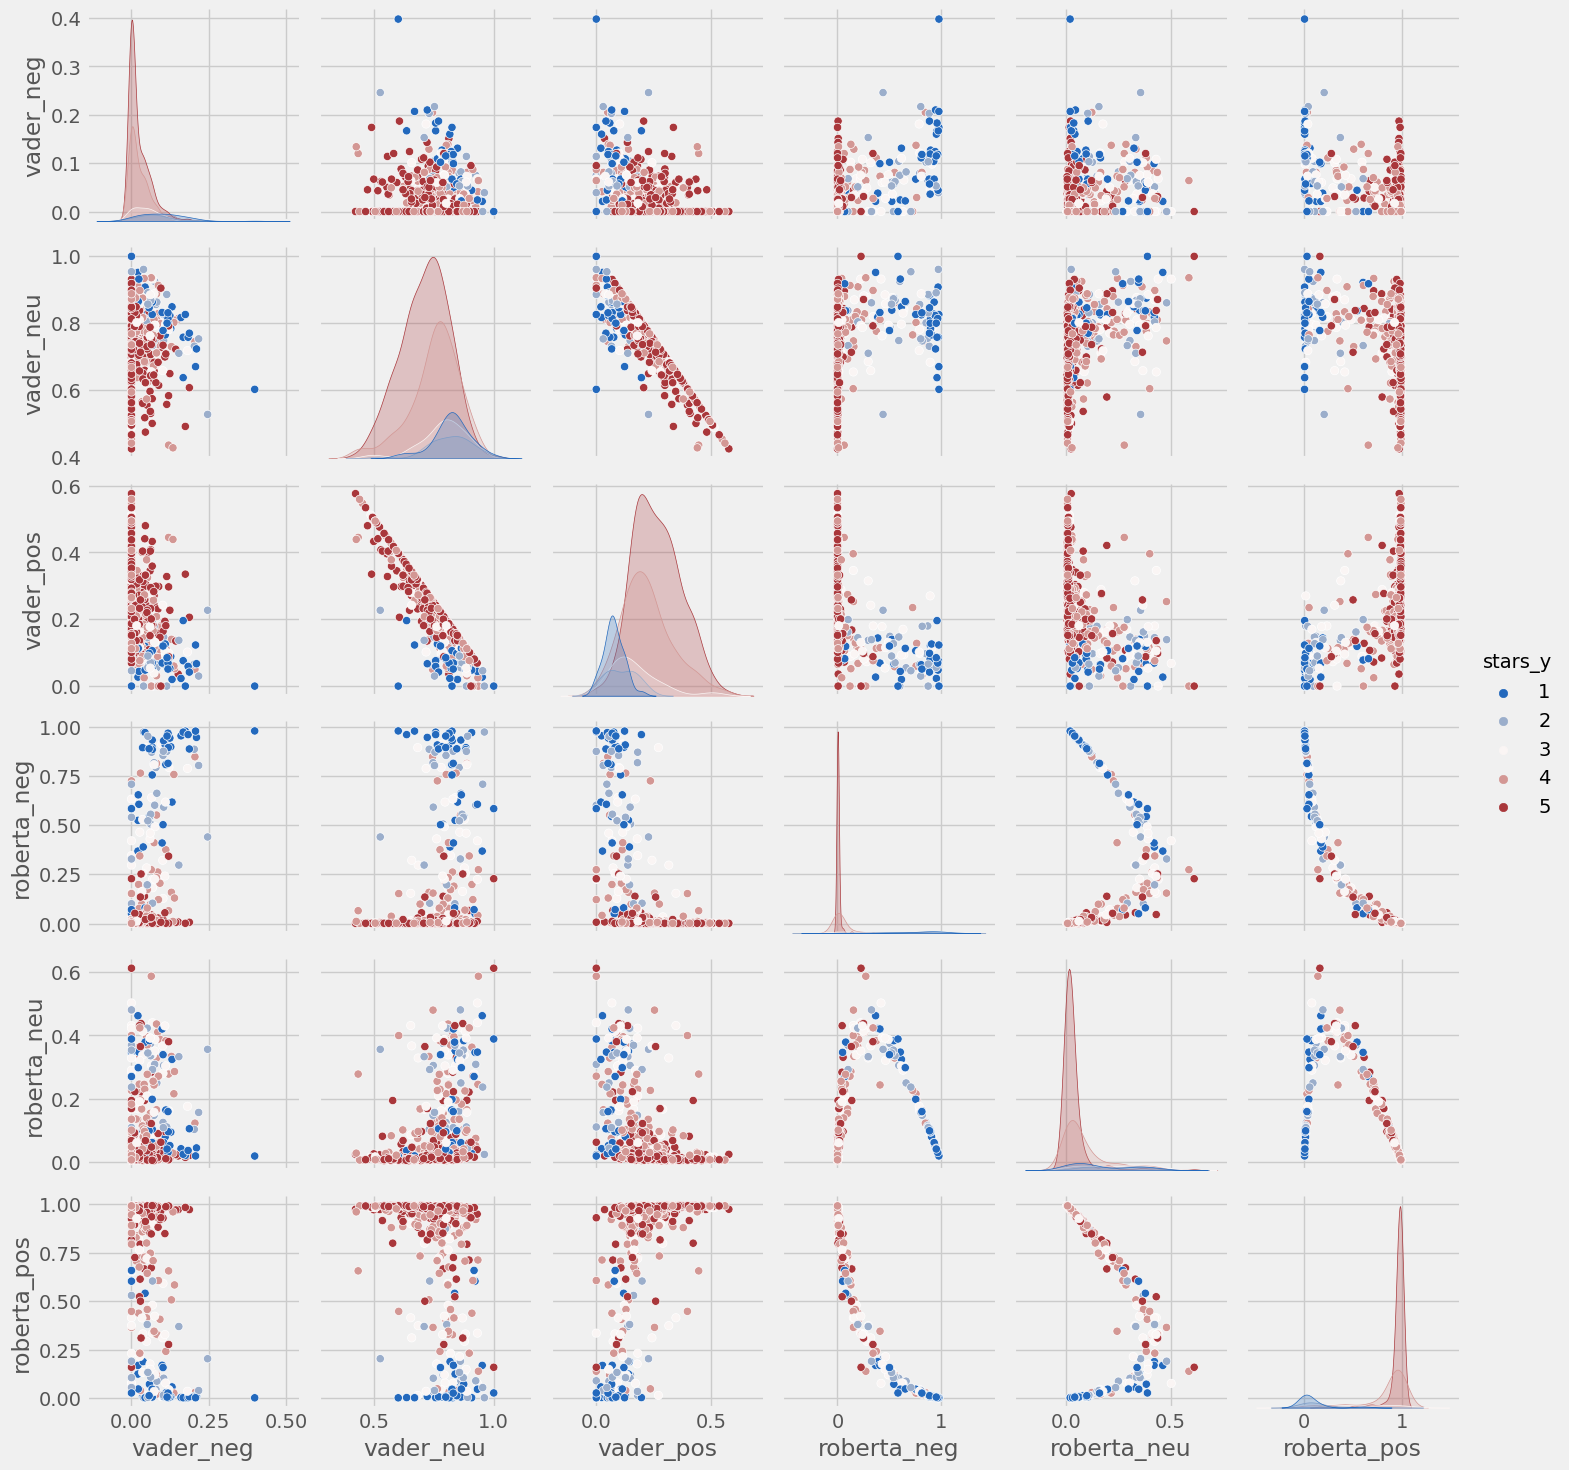

In [38]:
# plot the comparison
sns.pairplot(data=results_tucson,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='stars_y',
            palette='vlag')
plt.show()

### Starting with Time-Series

On the Tucson dataset

In [39]:
# show the data
tucson_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",xnA_bGa4zJ7fLUPTOCT0-A,nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",453I3aMT_YCQW655gKkzdQ,SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QTE44bHheG6ugQU4em4SdQ,B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",5f42pKbzLJWwtsa0StDwgA,OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-vIuycScTA7SVwHDi1ENeg,QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48


In [40]:
# drop unnecessary columns
columns_to_drop = ['postal_code', 'latitude', 'longitude', 'is_open', 'hours', 'useful', 'funny', 'cool']

# Use the drop method to remove the specified columns
tucson_data = tucson_data.drop(columns=columns_to_drop)

# show columns
tucson_data.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'stars_x',
       'review_count', 'attributes', 'categories', 'review_id', 'user_id',
       'stars_y', 'text', 'date'],
      dtype='object')

In [41]:
#set the date to index
tucson_data = tucson_data.set_index('date')
tucson_data.index = pd.to_datetime(tucson_data.index)

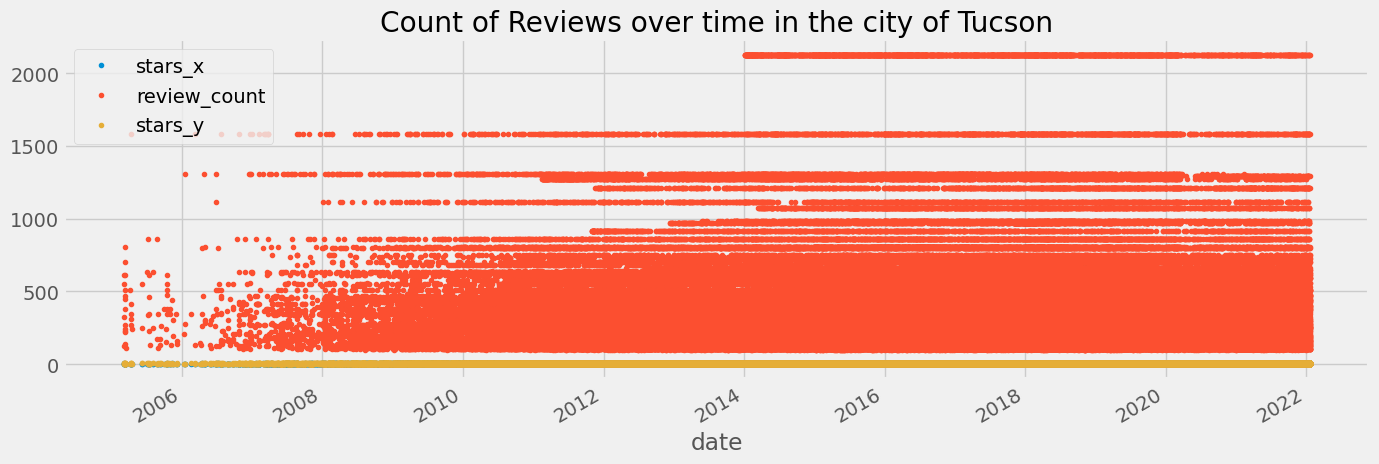

In [42]:
tucson_data.plot(style='.',
        figsize=(15, 5),
        title= 'Count of Reviews over time in the city of Tucson')
plt.show() # note: we should look at the green results, which represent the number of reviews!

<Axes: ylabel='Frequency'>

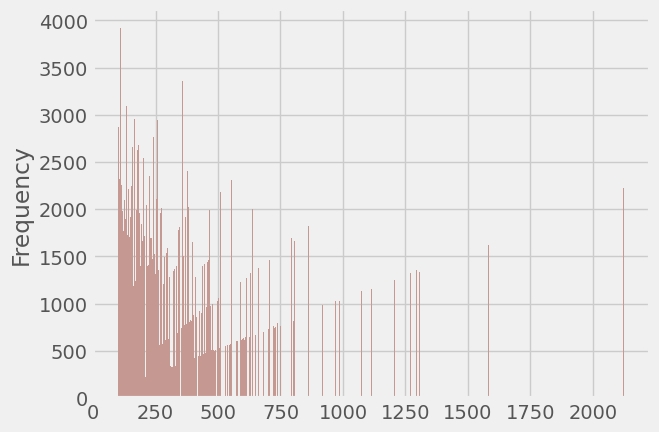

In [43]:
# outlier detection
tucson_data['review_count'].plot(kind='hist', bins=500, color='#c59992')

<Axes: title={'center': 'Extreme Outliers'}, xlabel='date'>

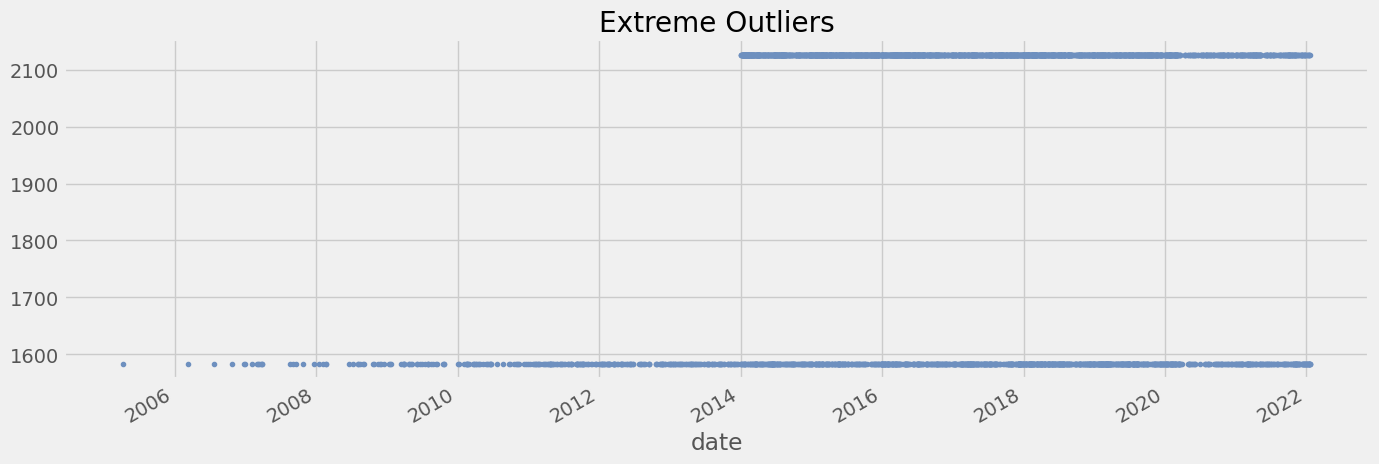

In [44]:
# extreme outliers
tucson_data.query('review_count > 1500')['review_count'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal,
          title='Extreme Outliers')

In [45]:
# remove extreme outliers
tucson_data = tucson_data.query('review_count < 1500').copy()

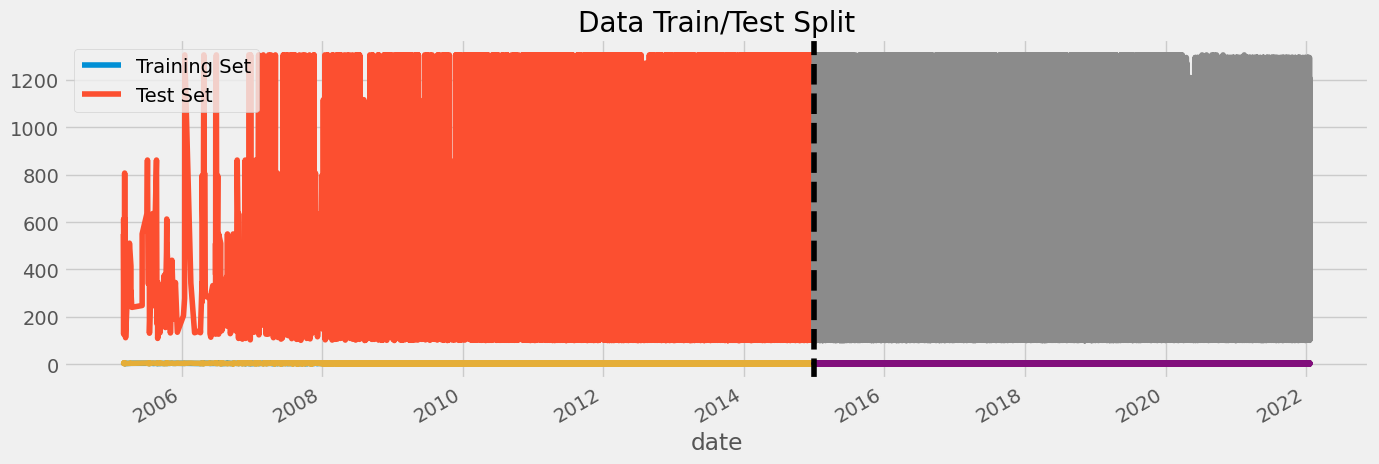

In [46]:
# lets start with ml

#define the train and test sets
train = tucson_data.loc[tucson_data.index < '01-01-2015']
test = tucson_data.loc[tucson_data.index >= '01-01-2015']

# let's plot the results
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

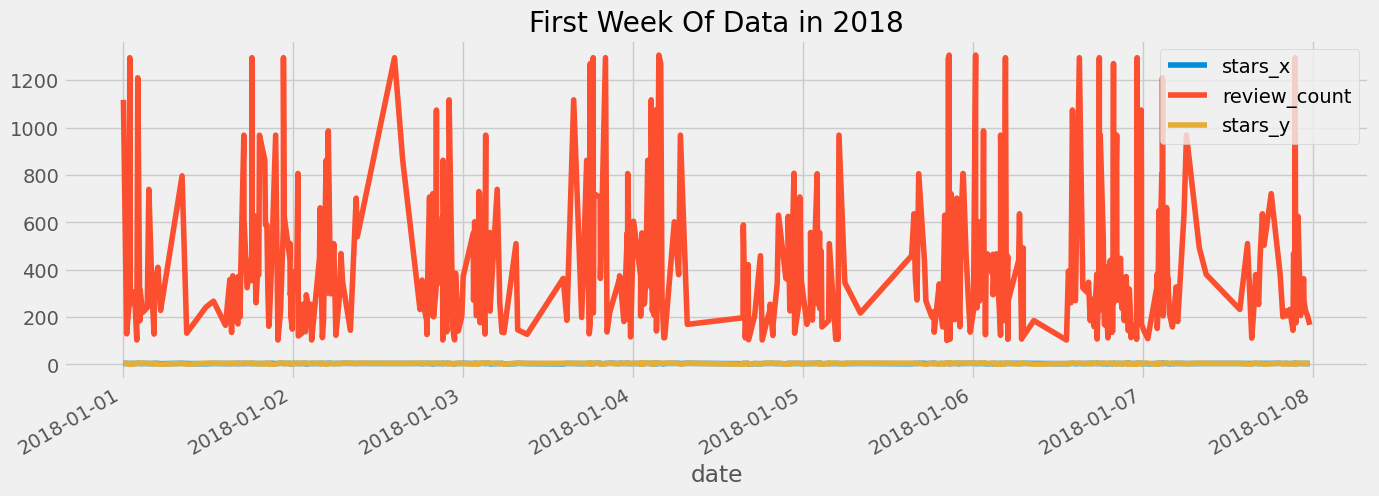

In [47]:
# let's plot the first week of data in 2018 (1 jan -> 8 jan )
tucson_data.loc[(tucson_data.index > '01-01-2018') & (tucson_data.index < '01-08-2018')] \
    .plot(figsize=(15, 5), title='First Week Of Data in 2018')
plt.show()

In [48]:
# Time-Series cross validation
from sklearn.model_selection import TimeSeriesSplit

# predict for approx. 6 months ahead
tss = TimeSeriesSplit(n_splits=2, test_size=8*180*1, gap=8)
tucson_data = tucson_data.sort_index()

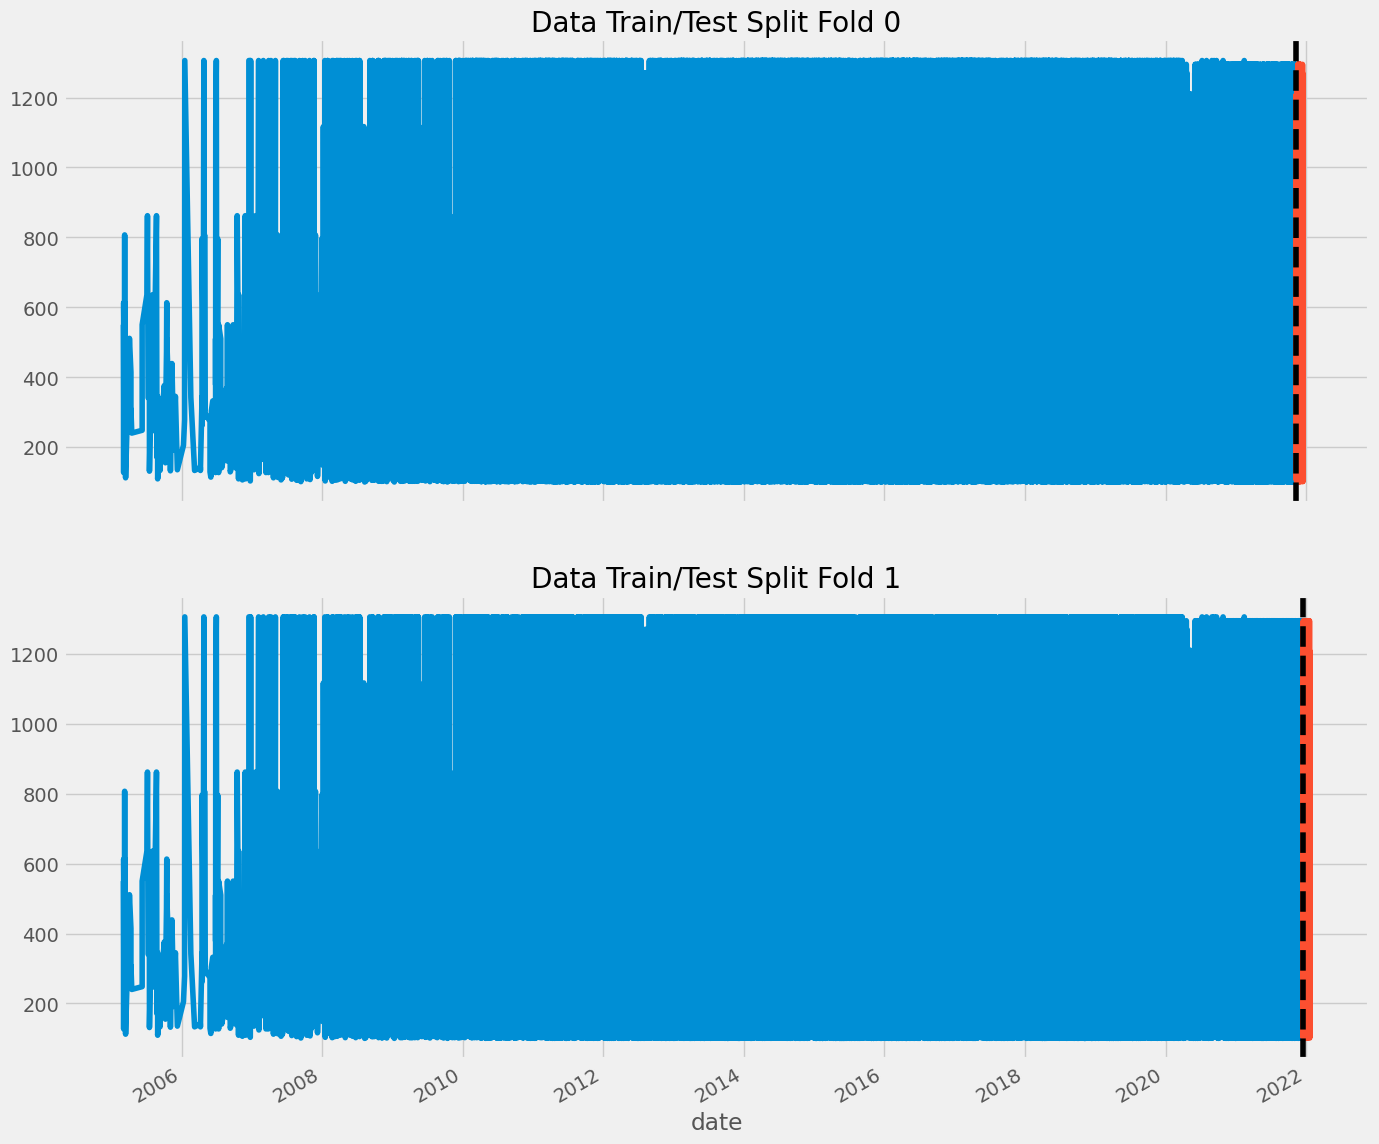

In [49]:
# plot it!
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(tucson_data):
    train = tucson_data.iloc[train_idx]
    test = tucson_data.iloc[val_idx]
    train['review_count'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['review_count'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [50]:
# forecasting horizon
# create features based on the date/datetime in our dataset
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = tucson_data.copy()
    tucson_data['hour'] = tucson_data.index.hour
    tucson_data['dayofweek'] = tucson_data.index.dayofweek
    tucson_data['quarter'] = tucson_data.index.quarter
    tucson_data['month'] = tucson_data.index.month
    tucson_data['year'] = tucson_data.index.year
    tucson_data['dayofyear'] = tucson_data.index.dayofyear
    tucson_data['dayofmonth'] = tucson_data.index.day
    tucson_data['weekofyear'] = tucson_data.index.isocalendar().week
    return tucson_data

df = create_features(tucson_data)

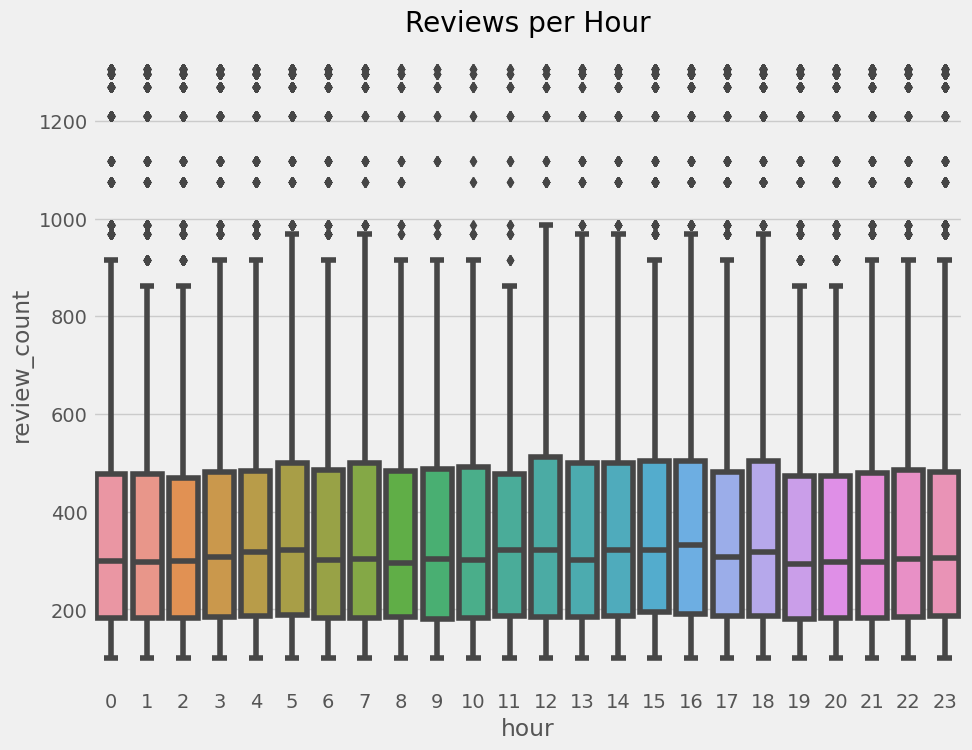

In [51]:
# let's plot the number of reviews per hour
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='review_count')
ax.set_title('Reviews per Hour')
plt.show()

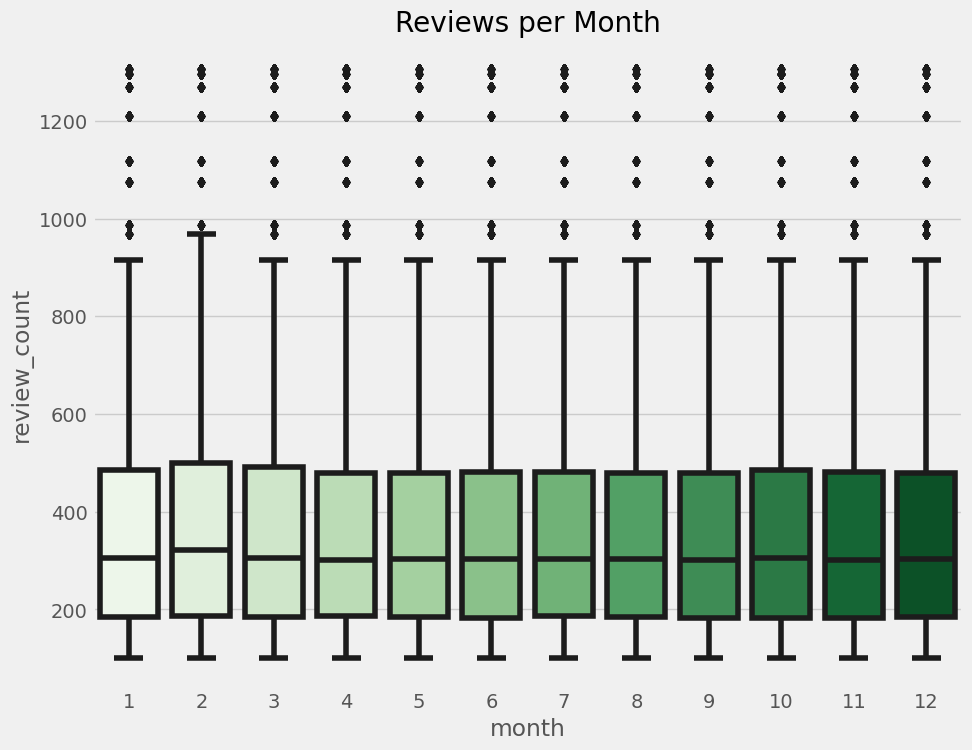

In [52]:
# let's do the same thing as above, but now for the months in a year
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='review_count', palette='Greens')
ax.set_title('Reviews per Month')
plt.show()

In [53]:
# lag features
# what was the target (x) days in the past
def add_lags(df):
    target_map = tucson_data['review_count'].to_dict()
    tucson_data['lag1'] = (tucson_data.index - pd.Timedelta('364 days')).map(target_map)
    tucson_data['lag2'] = (tucson_data.index - pd.Timedelta('728 days')).map(target_map)
    tucson_data['lag3'] = (tucson_data.index - pd.Timedelta('1092 days')).map(target_map)
    return tucson_data

In [54]:
tucson_data = add_lags(tucson_data)

In [55]:
tucson_data.tail()

,business_id,name,address,city,state,stars_x,review_count,attributes,categories,review_id,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
2022-01-19 18:43:23,gciMEyy9sIcwSMREEvNiXA,Roma Imports,627 S Vine Ave,Tucson,AZ,4.5,358,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Cheese Shops, Delis, Specialty Food, Restauran...",5219PwjFQvfQIXfb1mk7iA,...,2,1,1,2022,19,19,3,NaN,NaN,NaN
2022-01-19 18:45:14,T4E23iml3us2oH_OVGBr4Q,Gandhi Cuisine of India,150 W Fort Lowell Rd,Tucson,AZ,4.0,194,"{'RestaurantsTakeOut': 'True', 'Alcohol': ""u'b...","Food, Specialty Food, Imported Food, Indian, E...",4mN0514mm76_qNktS4Ogtg,...,2,1,1,2022,19,19,3,NaN,NaN,NaN
2022-01-19 18:47:42,dHpHptXgn1gpuxr_4DrMYQ,La Indita,722 N Stone Ave,Tucson,AZ,4.0,274,"{'Caters': 'True', 'BusinessAcceptsCreditCards...","Mexican, Restaurants, Vegetarian",TNe3zXBKNqDDVWQbefovuQ,...,2,1,1,2022,19,19,3,NaN,NaN,NaN
2022-01-19 18:58:18,eGi7CE2YaN6YMiGyXNi8XQ,Spice Garden Indian Cuisine,"5815 W Arizona Pavillions Dr, Ste 155",Tucson,AZ,4.5,105,"{'RestaurantsReservations': 'True', 'BYOB': 'F...","Restaurants, Indian, Vegetarian",WOYA_0Wj5aq9sM5UfPCbRQ,...,2,1,1,2022,19,19,3,NaN,NaN,NaN
2022-01-19 19:21:05,B10mqANgHvL8gBteo1UhAA,Caruso's,434 N 4th Ave,Tucson,AZ,3.5,381,"{'Alcohol': ""u'beer_and_wine'"", 'RestaurantsPr...","Restaurants, Italian, Pizza",QbPBkY_FglAoi3GQKS1Gbw,...,2,1,1,2022,19,19,3,NaN,NaN,NaN


In [56]:
# cross-valodation
tss = TimeSeriesSplit(n_splits=2, test_size=8*180*1, gap=8)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'review_count'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:460.81038	validation_1-rmse:460.81038


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:59:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:297.97542	validation_1-rmse:297.97542
[200]	validation_0-rmse:268.70161	validation_1-rmse:268.70161
[300]	validation_0-rmse:264.48546	validation_1-rmse:264.48546
[400]	validation_0-rmse:263.87913	validation_1-rmse:263.87913
[500]	validation_0-rmse:263.76889	validation_1-rmse:263.76889
[600]	validation_0-rmse:263.72900	validation_1-rmse:263.72900
[700]	validation_0-rmse:263.70062	validation_1-rmse:263.70062
[800]	validation_0-rmse:263.67545	validation_1-rmse:263.67545
[900]	validation_0-rmse:263.65427	validation_1-rmse:263.65427
[999]	validation_0-rmse:263.63458	validation_1-rmse:263.63458
[0]	validation_0-rmse:460.81038	validation_1-rmse:460.81038


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:00:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:297.97542	validation_1-rmse:297.97542
[200]	validation_0-rmse:268.70161	validation_1-rmse:268.70161
[300]	validation_0-rmse:264.48546	validation_1-rmse:264.48546
[400]	validation_0-rmse:263.87913	validation_1-rmse:263.87913
[500]	validation_0-rmse:263.76889	validation_1-rmse:263.76889
[600]	validation_0-rmse:263.72900	validation_1-rmse:263.72900
[700]	validation_0-rmse:263.70062	validation_1-rmse:263.70062
[800]	validation_0-rmse:263.67545	validation_1-rmse:263.67545
[900]	validation_0-rmse:263.65427	validation_1-rmse:263.65427
[999]	validation_0-rmse:263.63458	validation_1-rmse:263.63458


In [57]:
# print the scores
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 263.6346
Fold scores:[263.63457980012737, 263.63457980012737]


In [58]:
# predictions
# retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'review_count'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:460.81038


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:02:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:297.97542
[200]	validation_0-rmse:268.70161
[300]	validation_0-rmse:264.48546
[400]	validation_0-rmse:263.87913
[499]	validation_0-rmse:263.76964


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [59]:
df.index.max()

Timestamp('2022-01-19 19:21:05')

In [60]:
# create dataframe/table for future predictions
future = pd.date_range('2022-01-19','2023-01-19', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [61]:
future_w_features = df_and_future.query('isFuture').copy()

In [62]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features.shape

(0, 26)

In [63]:
#plot it!
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal,
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

IndexError: ignored

In [ ]:
# start the ML pipeline based on the features created
# the target should be the number of reviews
'''train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'review_count'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [ ]:
'''reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

In [ ]:
# define feature importance and plot it
'''fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color='olive')
plt.show() # we can conclude that 'year' is the most relevant feature

In [ ]:
# now let's try to forecast, on the test set
'''test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['review_count']].plot(figsize=(15, 5))
df[['prediction']].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Truth Data and Prediction')
plt.show()

In [ ]:
# now let's narrow the prediction just for one week
'''ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['review_count'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
# evaluation metrics: Root Mean Squared Error (RMSE)
'''score = np.sqrt(mean_squared_error(test['review_count'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}') # 332.90

In [ ]:
# now let's calculate the errors, by looking at the best predicted and worst predicted days
#test['error'] = np.abs(test[TARGET] - test['prediction'])
#test['date'] = test.index.date
#test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)